# Biomedical Imaging

## What is Image Segmentation?

Broadly, the segmentation problem stems from image **classification** which involves classifying objects in an entire image. 
- This involves the use of standard ConvNets.

Suppose we are interested in locating *where* these objects are; this is **object localization**. Localization typically involves using bounding box coordinates to encompass objects with their classes in an image. 
- For this problem we may want to use algorithms like YOLO.

Now suppose we want to go even deeper, an now classify *every* pixel in the image. This is known as **semantic segmentation**. Here, every single pixel in the image is assigned a class and allows the separation of different classes and their shapes in an image. 
- One of the stand-out network architectures in this field include U-Nets.

Finally, what if we want to segment individual object instances (rather than classifying all like objects with the same class)? We can perform **instance segmentation**. Here, objects are individually assigned rather than all being classified under the same object. 
- Mask R-CNNs can be applied to this problem to provide a classification, bounding box, and segmentation.

## Standard Classification Application in Pneumonia Diagnosis

Here I will demonstrate a standard implementation of classification on [this chest x-ray pneumonia](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) dataset. 

The models:

- EfficientNetB7 pretrained imagenet weights for transfer learning
- Modified top layer with global average pooling, dropout, and a binary classifier

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
BATCH_SIZE = 64
IMG_SIZE = (256, 256)

directory = "Data/chest_xray/train"

# Generate tensorflow dataset
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=8)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=8)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [12]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

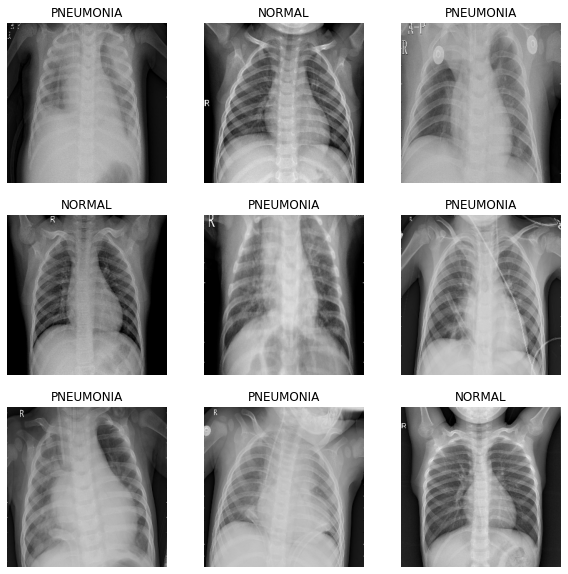

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Here we prefetch the data to prevent memory bottlenecks (no need to fit data into memory).

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [20]:
def pneumonia_model(image_shape = IMG_SIZE):
    """
    Defines a tf.keras model to perform binary classification on lungs infected with pneumonia. 
    Arguments:
        image_shape = image width and height (pre-specified)
    Returns:
        tf.keras.model
    """
    
    input_shape = image_shape + (3,)
    
    base = tf.keras.applications.EfficientNetB7(input_shape = input_shape,
                                               include_top = False,
                                               weights = 'imagenet')
    
    base.trainable = False
    
    inputs = tf.keras.Input(shape = input_shape)

    x = base(inputs, training=False)
    
    # new classification layers
    
    x = tfl.GlobalAveragePooling2D()(x)
    
    x = tfl.Dropout(0.3)(x)
    
    prediction_layer = tfl.Dense(1, activation = "linear")
    
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

In [21]:
pneu_mod = pneumonia_model(IMG_SIZE)

We have now created a new model to perform binary classification based on the EfficientNetB7 pretrained imagenet CNN. We replaced the top layer with a global average pooling (to summarize info and generalize dims), dropout regularization (to prevent overfitting), and a single dense layer output for binary classification.

In [23]:
pneu_mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
_________________________________________________________________


In [25]:
base_lr = 0.001
pneu_mod.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_lr),
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = ['accuracy'])

In [27]:
initial_epochs = 5
history = pneu_mod.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
66/66 [==============================] - 125s 1s/step - loss: 0.3092 - accuracy: 0.8766 - val_loss: 0.1846 - val_accuracy: 0.9396
Epoch 2/5
66/66 [==============================] - 80s 1s/step - loss: 0.1799 - accuracy: 0.9422 - val_loss: 0.1384 - val_accuracy: 0.9521
Epoch 3/5
66/66 [==============================] - 81s 1s/step - loss: 0.1503 - accuracy: 0.9463 - val_loss: 0.1239 - val_accuracy: 0.9559
Epoch 4/5
66/66 [==============================] - 81s 1s/step - loss: 0.1308 - accuracy: 0.9521 - val_loss: 0.1119 - val_accuracy: 0.9588
Epoch 5/5
66/66 [==============================] - 81s 1s/step - loss: 0.1238 - accuracy: 0.9526 - val_loss: 0.1049 - val_accuracy: 0.9626


Here, on the validation set we can immediately see a very good accuracy in only 5 epochs. 

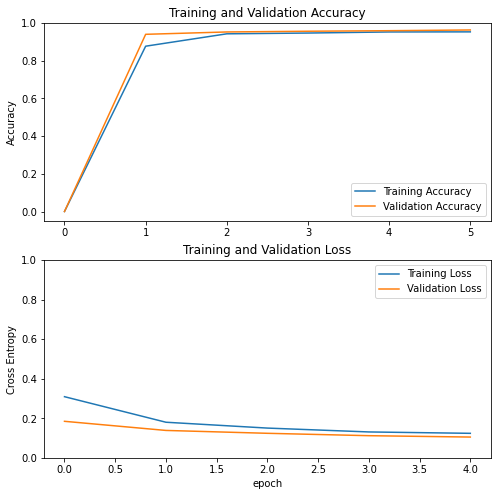

In [28]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

How well does the model do on new data?

In [29]:
test_dir = "Data/chest_xray/test"

test_dataset = image_dataset_from_directory(test_dir, shuffle=True)

Found 624 files belonging to 2 classes.


In [30]:
test_hist = pneu_mod.evaluate(test_dataset)

20/20 [==============================] - 15s 604ms/step - loss: 0.5055 - accuracy: 0.8285


Here our test accuracy is ~83% which is decent for an initial model. We could potentially increase effectiveness by retraining some of the higher-level layers to finer details specific for X-rays. Having a much higher validation accuracy suggests potential overfitting, but retraining the higher level layers and adding more regularization may help!

## Mask R-CNN [MRCNN - TF/Keras](https://github.com/matterport/Mask_RCNN)

Mask R-CNN builds on R-CNN (object localization) by adding a mask. This implementation specifically uses this [verson](https://github.com/leekunhee/Mask_RCNN) adapted for TensorFlow 2 functionality.

In [ ]:
# Helpers
import os
import random
import math
import re
import time
import numpy as np
import cv2

# MRCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Setup
ROOT_DIR = os.path.abspath(".")


## References

1. [Andrew Ng's deep learning specialization (CNNs)](https://www.coursera.org/learn/convolutional-neural-networks/home/welcome)
2. [Microsoft COCO: Common Objects in Context, Lin et. al.](https://arxiv.org/pdf/1405.0312.pdf)
3. [Mask R-CNN, He et. al.](https://arxiv.org/pdf/1703.06870.pdf)
4. [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning, Kermany et. al.](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)